# Spaxel stacking and masking
For context, see notebook `get_data_PSB_spaxels_only2`. Continuing that notebook, the decision made is to use option 6: For mask, use the union (and) of the "PCA_qualmask" and the default MaNGA qualmask calculated from H alpha maps. Also no SNR cuts will be used since we will be stacking the voronoi-binned cubes. <br>
This notebook takes the raw cubes, masks them according to this method, and saves out stacked spectra for the 15  PSBs.

In [1]:
import time
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
import marvin
import pandas as pd
from PyAstronomy import pyasl

[INFO]: No release version set. Setting default to DR15
[WARNING]: path /Users/hinleung/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /Users/hinleung/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject (RuntimeWarning)
[WARNING]: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject (RuntimeWarning)


In [2]:
# skylines
lines_air_df = pd.read_fwf('../skylines.txt')
lines_vac = pyasl.airtovac2(lines_air_df[lines_air_df['flux']>=30]['wavelength'])
print(lines_vac)

def mask_sky(wave, masksize=10):
    """ Masks strong night sky emission lines that are often not removed 
    properly in the data processing. From masksky.pro """

    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    return mask, np.array([lines-masksize, lines+masksize]).T

[5578.8954556  6302.05104962 6365.54219491 8346.90679765 8401.48404869
 8401.48404869 8829.53629684 8888.29629305 8922.08573476 9315.90131855
 9326.32113949 9378.54917978 9442.25973032 9479.49541313 9793.80124247
 9874.8545013  9917.49585452 9949.24175613 9959.32848922]


In [3]:
# setup functions
class galaxy:

    def __init__(self, plateifu):
        # first get all relevent cubes and masks and fits files and PCA labels
        self.DRPcube = marvin.tools.Cube(plateifu)
        if self.DRPcube.mode == 'remote':
            self.DRPcube.download()
        self.DAPcube = marvin.tools.ModelCube(plateifu)
        if self.DAPcube.mode == 'remote':
            self.DAPcube.download()
        self.maps = marvin.tools.Maps(plateifu)
        if self.maps.mode == 'remote':
            self.maps.download()
        ha_qual = self.maps['emline_gflux_ha_6564']
        PCA_file = "./from_colaborators/ALMA_PSBs_PCAmaps/manga-"+plateifu+"_PCA.fits"
        self.PCA_fits = fits.open(PCA_file)
        self.PCA_qualmask = 1-self.PCA_fits[7].data
        self.PSB_mask = self.PCA_fits[10].data==5
        
        # get Ha qualmask from marvin
        nocov = ha_qual.pixmask.get_mask('NOCOV')
        lowcov = ha_qual.pixmask.get_mask('LOWCOV')
        donotuse = ha_qual.pixmask.get_mask('DONOTUSE')
        deadfiber = ha_qual.pixmask.get_mask('DEADFIBER')
        forestar = ha_qual.pixmask.get_mask('FORESTAR')
        qualmask_ = ( (nocov) | (lowcov) | (donotuse) | (deadfiber) | (forestar) )
        self.qualmask = (qualmask_==0)
        
        # Milky way reddening correction
        self.cube_redcorr = self.DAPcube._redcorr
        cube_redcorr_ = self.cube_redcorr[:,np.newaxis,np.newaxis]
        self.corrected_flux = self.DRPcube.flux.value*cube_redcorr_
        self.corrected_ivar = self.DRPcube.flux.ivar/cube_redcorr_**2
        
        self.binned_corrected_flux = self.DAPcube.binned_flux.value*cube_redcorr_
        self.binned_corrected_ivar = self.DAPcube.binned_flux.ivar/cube_redcorr_**2
        
        # SNR calculations
        self.snr = np.mean(self.DRPcube.flux.snr,axis=0)
        self.binned_snr = np.mean(self.DAPcube.binned_flux.snr,axis=0)
        
    def stack(self, binned=False, SNR_threshold=None, qualmask_choice='default', vb=True):
        if binned:
            wavelength = self.DRPcube.flux.wavelength.value.copy()
            flux = self.binned_corrected_flux.copy()
            ivar = self.binned_corrected_ivar.copy()
            snr = self.binned_snr.copy()
        else:
            wavelength = self.DAPcube.binned_flux.wavelength.value.copy()
            flux = self.corrected_flux.copy()
            ivar = self.corrected_ivar.copy()
            snr = self.snr.copy()
            
        if qualmask_choice == 'default':
            qualmask = self.qualmask.copy()
        elif qualmask_choice == 'PCA':
            qualmask = self.PCA_qualmask.copy()
        elif qualmask_choice == 'both':
            qualmask = self.PCA_qualmask * self.qualmask
        
        if SNR_threshold is None:
            self.combined_mask = qualmask * self.PSB_mask
        else:
            self.combined_mask = qualmask * self.PSB_mask * (snr>SNR_threshold)
        
        self.wavelength, self.spectrum, self.errors = self.stacking(wavelength, flux, ivar, self.combined_mask)
        
        if vb:
            o_mask = (self.qualmask & (self.snr>15))
            o_wavelength, o_spectrum, o_errors = self.stacking(self.DRPcube.flux.wavelength.value.copy(), 
                                                               self.binned_corrected_flux.copy(), 
                                                               self.binned_corrected_ivar.copy(), 
                                                               o_mask)
            print("previous masking stacked mean SNR:", np.mean(o_spectrum/o_errors))
            print("this masking stacked mean SNR:", np.mean(self.spectrum/self.errors))
            
            fig = plt.figure(figsize=[10,10])
            gs = matplotlib.gridspec.GridSpec(2,2)
            ax1 = plt.subplot(gs[0,0])
            ax2 = plt.subplot(gs[0,1])
            ax3 = plt.subplot(gs[1,:])
            
            ax1.imshow(o_mask, cmap='jet')
            ax1.set_title( r"previous masking")
            ax1.set_xlabel('x[pixel]')
            ax1.set_ylabel('y[pixel]')
            ax3.plot(o_wavelength, o_spectrum, label='previous')
            ax3.fill_between(o_wavelength, o_spectrum-o_errors, o_spectrum+o_errors)
            
            ax2.imshow(self.combined_mask, cmap='jet')
            ax2.set_title( r"this masking")
            ax2.set_xlabel('x[pixel]')
            ax2.set_ylabel('y[pixel]')
            ax3.plot(self.wavelength, self.spectrum, label='this')
            ax3.fill_between(self.wavelength, self.spectrum-self.errors, self.spectrum+self.errors)
            
            ax3.legend()
            ax3.set_xlim([min(self.wavelength),max(self.wavelength)])
            ax3.set_xlabel('wavelength[$\AA$]')
            ax3.set_ylabel('$f_\lambda \;/\; erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$')
            plt.show()
        
    def stacking(self, wavelength, flux, ivar, mask):
        masked_flux = mask * flux
        
        contribution_cube = np.zeros(np.shape(masked_flux))
        contribution_cube = mask * (1-(ivar==0))
        
        valid_pix_spectrum_cube = contribution_cube * masked_flux
        valid_pix_var_cube = np.where(contribution_cube==1, 1/ivar, 0)

        contribution_list = np.sum(contribution_cube, axis=(1,2))
        spectrum = np.sum(valid_pix_spectrum_cube, axis=(1,2)) \
                   *10**-17*max(contribution_list)/contribution_list
        errors = np.sqrt(np.sum(valid_pix_var_cube, axis=(1,2))) \
                 *10**-17*max(contribution_list)/contribution_list
        
        #dropping wavelength pixels that have summed error = 0
        zero_ind = np.where((errors==0)|(contribution_list==0)|(spectrum<=0))
        wavelength = np.delete(wavelength, zero_ind)
        spectrum = np.delete(spectrum, zero_ind)
        errors = np.delete(errors, zero_ind)
        
        return wavelength, spectrum, errors
        

Using the ringed PSB 8083-12703 for demonstration. The next cell plots its flux at 4559.3 anstroms, spaxel mean unbinned SNR, spaxel mean binned SNR, MaNGA H-alpha qualmask, PCA qualmask and the PCA spaxel labelling.

[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)


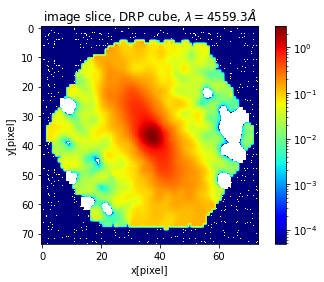

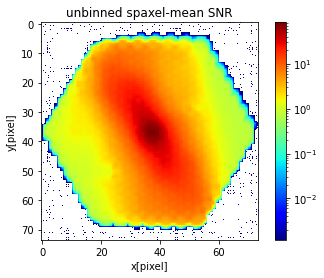

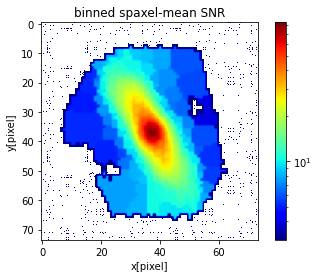

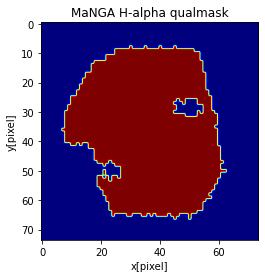

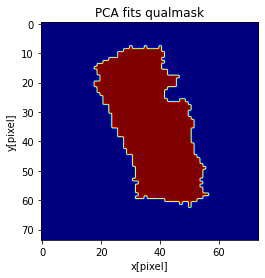

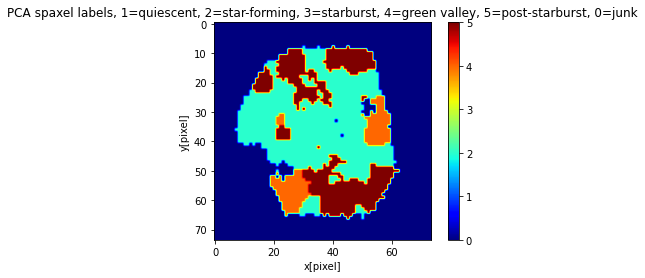

In [4]:
plateifu = '8083-12703'
gal = galaxy(plateifu)

#flux
idx = 1000
plt.imshow(gal.corrected_flux[idx], norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( r"image slice, DRP cube, $\lambda=%.1f\AA$" %gal.DRPcube.flux.wavelength[idx].value)
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#unbinned SNR
plt.imshow(gal.snr, norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( "unbinned spaxel-mean SNR")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#binned SNR
plt.imshow(gal.binned_snr, norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( "binned spaxel-mean SNR")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#MaNGA Ha qualmask
plt.imshow(gal.qualmask, cmap='jet')
plt.title( "MaNGA H-alpha qualmask")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#PCA fits qualmask
plt.imshow(gal.PCA_qualmask, cmap='jet')
plt.title( "PCA fits qualmask")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

#PCA fits qualmask
temp_map = gal.PCA_fits[10].data.copy()
mask = gal.PCA_fits[10].data<0
temp_map[mask] = 0
plt.imshow(temp_map, cmap='jet')
plt.colorbar()
plt.title( "PCA spaxel labels, 1=quiescent, 2=star-forming, 3=starburst, 4=green valley, 5=post-starburst, 0=junk")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

### Masking and stacking option taken:

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


previous masking stacked mean SNR: 620.6500820645539
this masking stacked mean SNR: 274.5387685321849


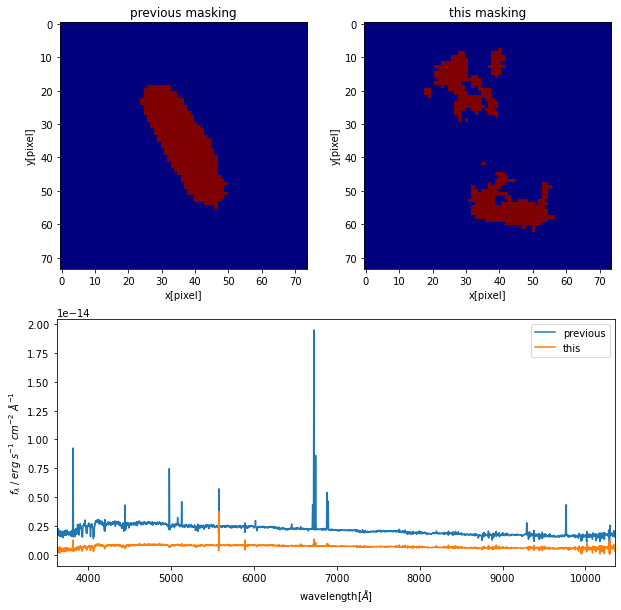

In [5]:
gal.stack(binned=True, SNR_threshold=None, qualmask_choice='both')

## Shifting to show all galaxies

In [6]:
targets = pd.read_fwf('PSBs_ALMAobs_sample.txt')
IDs = targets['plateifu']

galaxies = []
for plateifu in IDs:
    galaxies.append(galaxy(plateifu))

[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: mismatch betw

[WARNING]: unclosed file <_io.FileIO name='./from_colaborators/ALMA_PSBs_PCAmaps/manga-8083-12703_PCA.fits' mode='rb' closefd=True> (ResourceWarning)


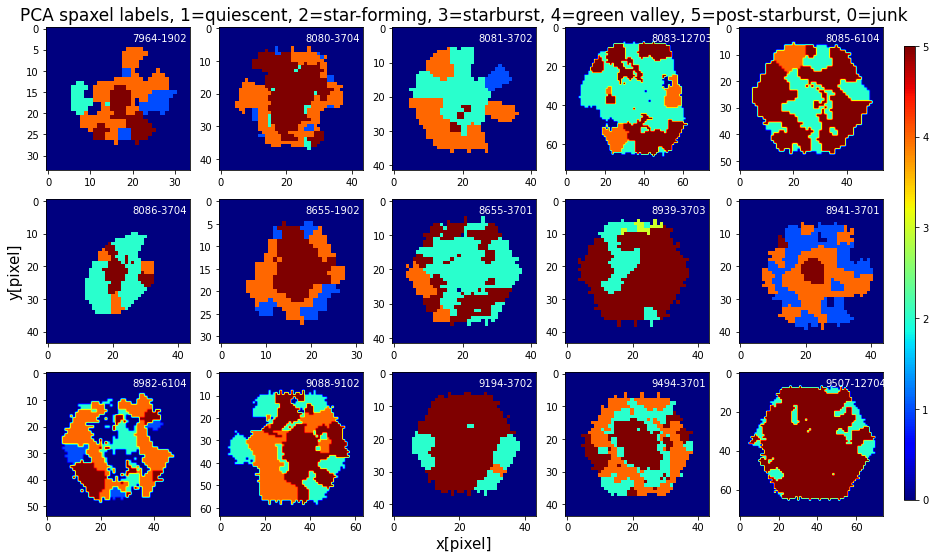

In [7]:
# PCA labelling
fig, ax = plt.subplots(3,5, figsize=[15,9])
for i,gal in enumerate(galaxies):
    axi = ax[i // 5, i % 5]
    temp_map = gal.PCA_fits[10].data.copy()
    mask = gal.PCA_fits[10].data<0
    temp_map[mask] = 0
    im = axi.imshow(temp_map, cmap='jet')
    axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='white')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

ax[2,2].set_xlabel('x[pixel]', fontsize=15)
ax[1,0].set_ylabel('y[pixel]', fontsize=15)
ax[0,2].set_title('PCA spaxel labels, 1=quiescent, 2=star-forming, 3=starburst, 4=green valley, 5=post-starburst, 0=junk'
                  , fontsize=17)
plt.show()

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


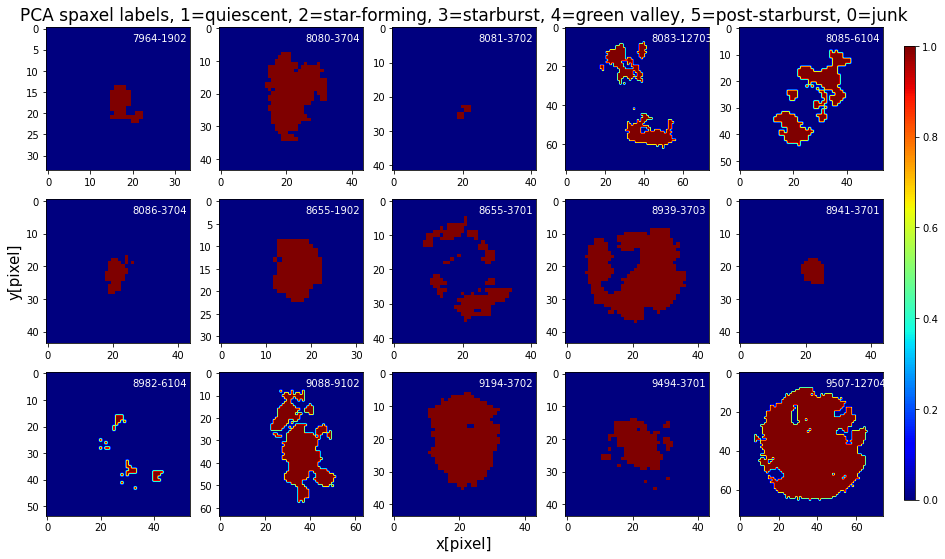

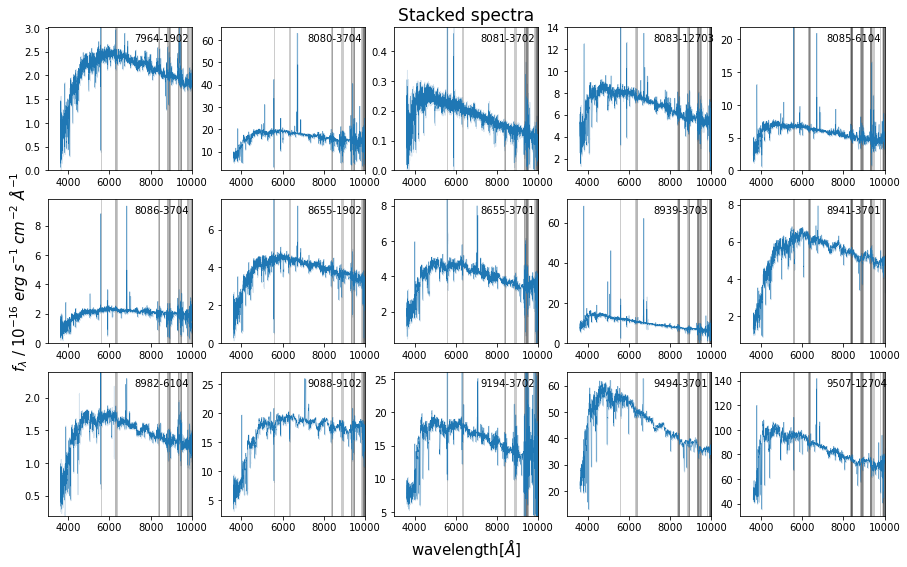

In [8]:
# masking maps
fig, ax = plt.subplots(3,5, figsize=[15,9])
for i,gal in enumerate(galaxies):
    axi = ax[i // 5, i % 5]
    gal.stack(binned=True, SNR_threshold=None, qualmask_choice='both', vb=False)
    im = axi.imshow(gal.combined_mask, cmap='jet')
    axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='white')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

ax[2,2].set_xlabel('x[pixel]', fontsize=15)
ax[1,0].set_ylabel('y[pixel]', fontsize=15)
ax[0,2].set_title('PCA spaxel labels, 1=quiescent, 2=star-forming, 3=starburst, 4=green valley, 5=post-starburst, 0=junk'
                  , fontsize=17)
plt.show()

# stacked spectra
fig, ax = plt.subplots(3,5, figsize=[15,9])
for i,gal in enumerate(galaxies):
    axi = ax[i // 5, i % 5]
    spec_mask, mask_lims = mask_sky(gal.wavelength)
    spec_masked = np.delete(gal.spectrum, spec_mask)
    ylims = np.array([min(spec_masked[np.delete(gal.wavelength.copy(), spec_mask)<10000]),
                      max(spec_masked[np.delete(gal.wavelength.copy(), spec_mask)<10000])])*10**16
    ylims = [ylims[0]-np.diff(ylims)*0.05, ylims[1]+np.diff(ylims)*0.05]
    axi.plot(gal.wavelength, gal.spectrum*10**16, lw=0.3)
    #print(min(gal.errors), max(gal.errors), np.shape(gal.errors))
    axi.fill_between(gal.wavelength, gal.spectrum*10**16-gal.errors*10**16, gal.spectrum*10**16+gal.errors*10**16,
                    color='steelblue', alpha=0.2)
    for mask_lim_i in mask_lims:
        axi.fill_between(mask_lim_i, ylims[1], ylims[0], color='black', alpha=0.2)
    axi.set_xlim(3000,10000)
    axi.set_ylim([max([ylims[0],0]),ylims[1]])
    axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='black')

ax[2,2].set_xlabel('wavelength[$\AA$]', fontsize=15)
ax[1,0].set_ylabel('$f_\lambda \;/\; 10^{-16} \;erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$', fontsize=15)
ax[0,2].set_title('Stacked spectra', fontsize=17)
plt.show()

In [10]:
# Saving out the spectra
for i,gal in enumerate(galaxies):
    save_df = pd.DataFrame({'observed-wave[AA]':gal.wavelength.byteswap().newbyteorder(),
                            'flux[10^-16 erg/s/cm^2/AA]':gal.spectrum.byteswap().newbyteorder()*10**16, 
                            'noise[10^-16 erg/s/cm^2/AA]':gal.errors.byteswap().newbyteorder()*10**16})
    save_name = 'MaNGA_spectrums/Spectrum_'+IDs[i]+'_PSBonly_dereddened.csv'
    print(save_name)
    save_df[save_df['observed-wave[AA]'].between(3000,9500)].to_csv(save_name, index=False)

MaNGA_spectrums/Spectrum_7964-1902_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8080-3704_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8081-3702_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8083-12703_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8085-6104_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8086-3704_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8655-1902_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8655-3701_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8939-3703_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8941-3701_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_8982-6104_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_9088-9102_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_9194-3702_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_9494-3701_PSBonly_dereddened.csv
MaNGA_spectrums/Spectrum_9507-12704_PSBonly_dereddened.csv


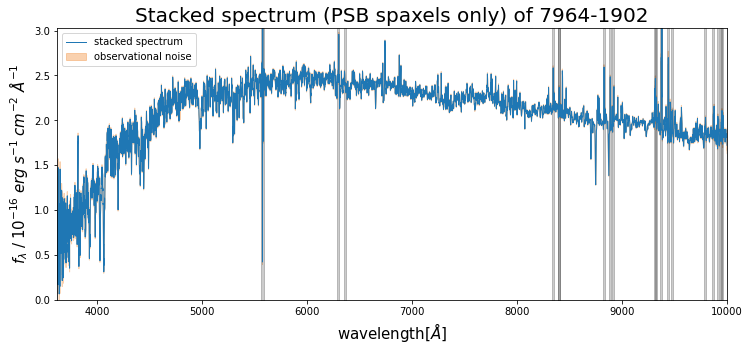

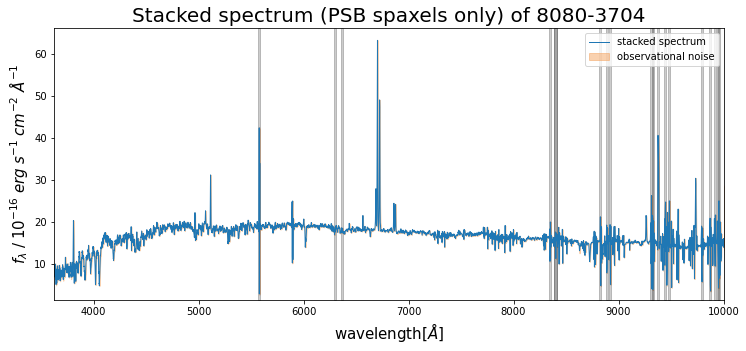

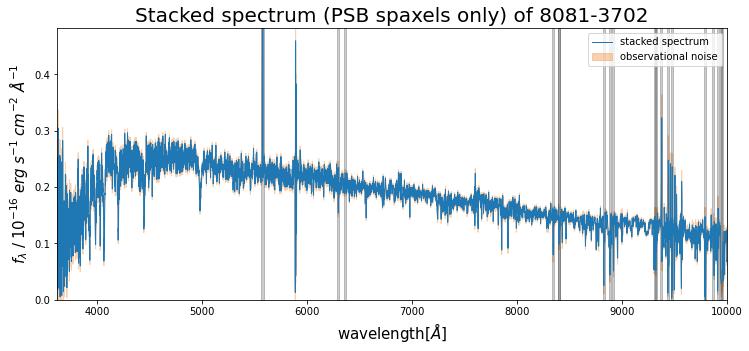

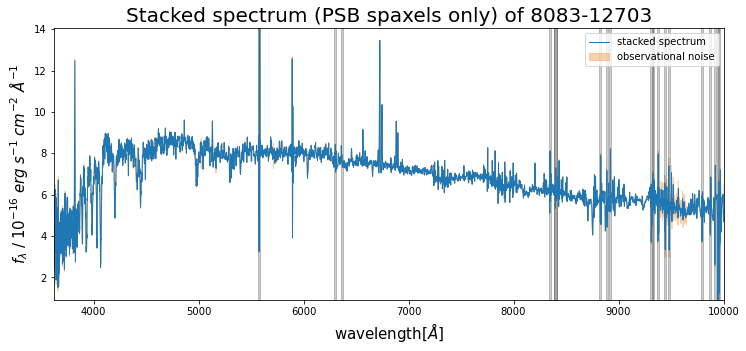

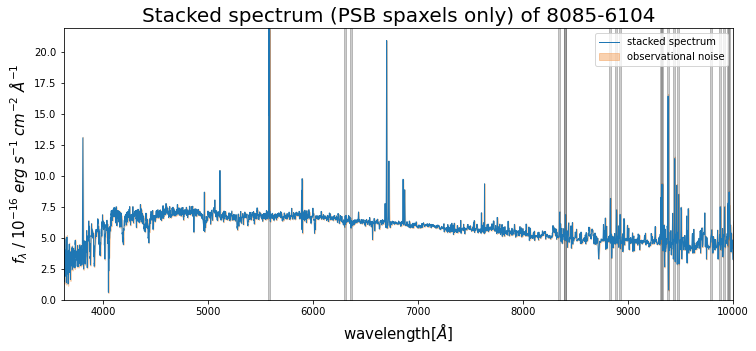

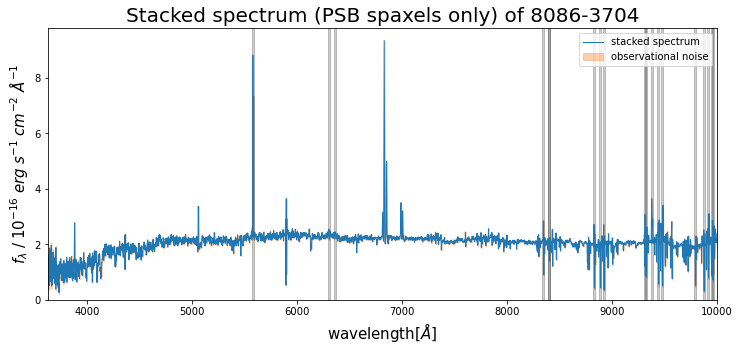

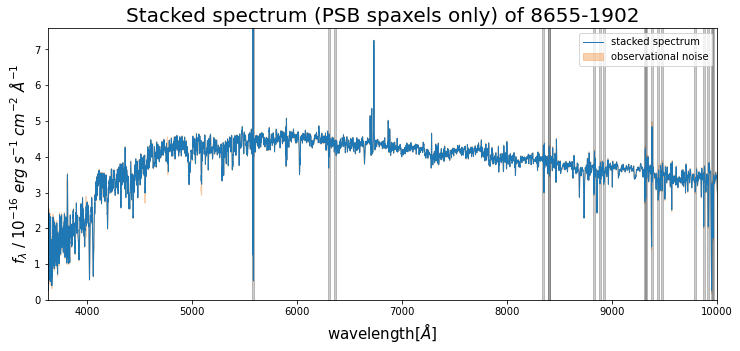

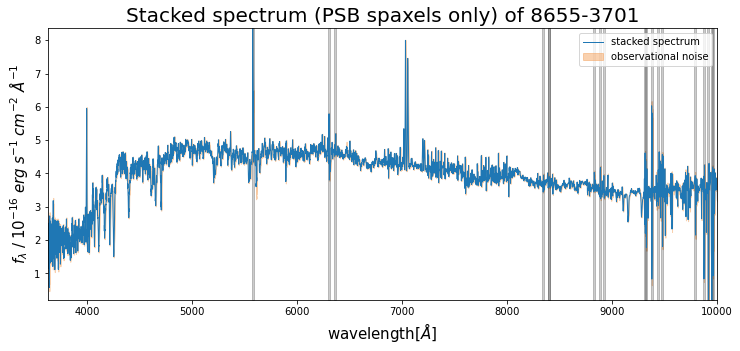

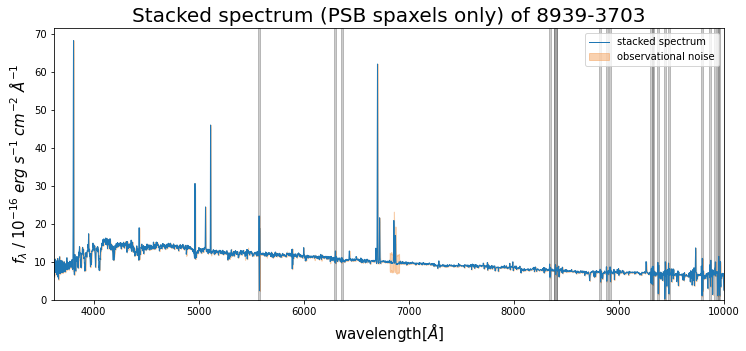

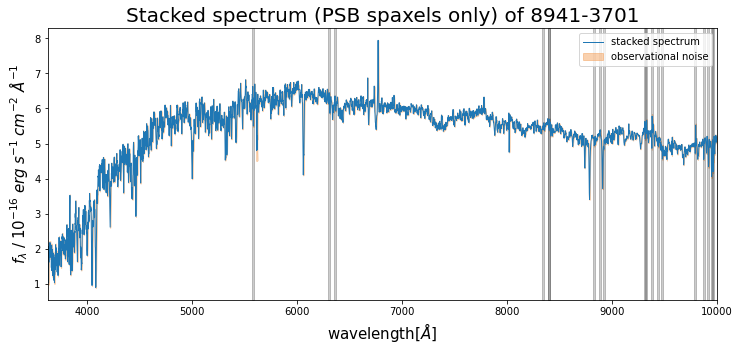

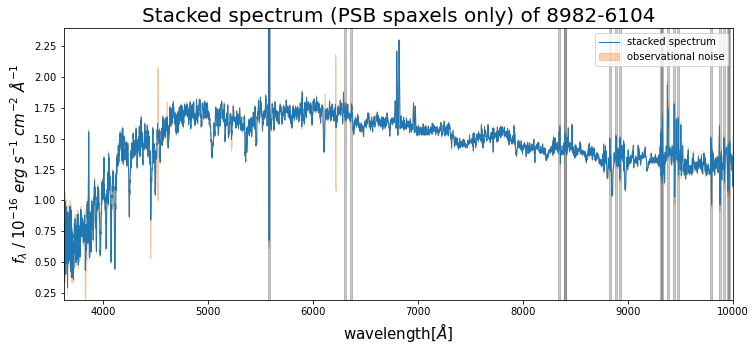

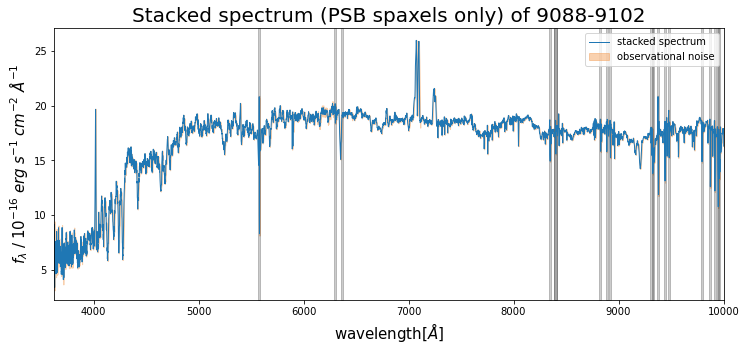

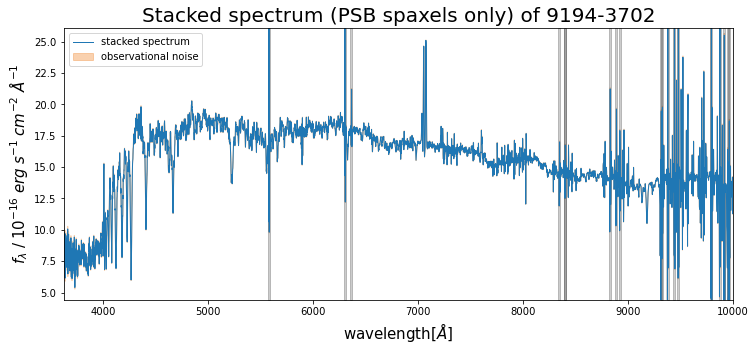

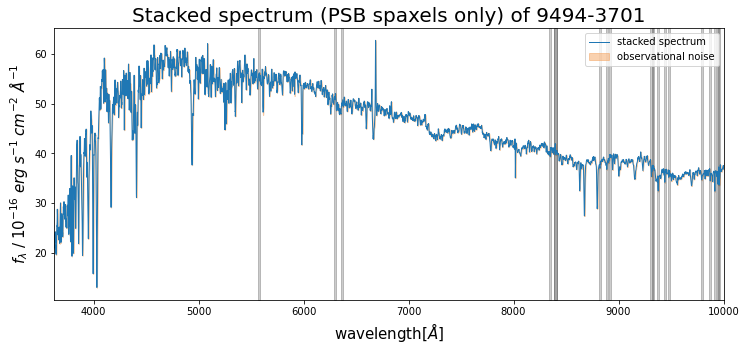

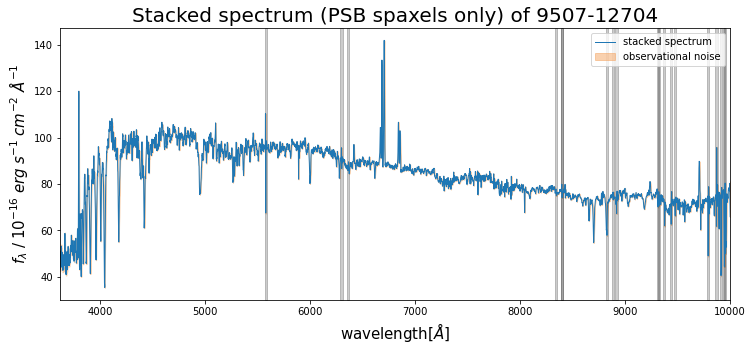

In [199]:
for i,gal in enumerate(galaxies):
    fig, ax = plt.subplots(figsize=[12,5])
    spec_mask, mask_lims = mask_sky(gal.wavelength)
    spec_masked = np.delete(gal.spectrum, spec_mask)
    ylims = np.array([min(spec_masked[np.delete(gal.wavelength.copy(), spec_mask)<10000]),
                      max(spec_masked[np.delete(gal.wavelength.copy(), spec_mask)<10000])])*10**16
    ylims = [ylims[0]-np.diff(ylims)*0.05, ylims[1]+np.diff(ylims)*0.05]
    ax.plot(gal.wavelength, gal.spectrum*10**16, lw=1, label='stacked spectrum')
    #print(min(gal.errors), max(gal.errors), np.shape(gal.errors))
    ax.fill_between(gal.wavelength, gal.spectrum*10**16-gal.errors*10**16, gal.spectrum*10**16+gal.errors*10**16,
                    color='sandybrown', alpha=0.5, label='observational noise')
    for mask_lim_i in mask_lims:
        ax.fill_between(mask_lim_i, ylims[1], ylims[0], color='black', alpha=0.2)
    ax.set_xlim([min(gal.wavelength),10000])
    ax.set_ylim([max([ylims[0],0]),ylims[1]])
    ax.set_xlabel('wavelength[$\AA$]', fontsize=15)
    ax.set_ylabel('$f_\lambda \;/\; 10^{-16} \;erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$', fontsize=15)
    ax.set_title("Stacked spectrum (PSB spaxels only) of "+IDs[i], fontsize=20)
    ax.legend()
    fig.savefig('MaNGA_spectrums/plots/Spectrum_'+IDs[i]+'_PSBonly_dereddened.pdf')
    plt.show()

### Experimentation around spaxel-by-spaxel fitting masking

In [181]:
# only take one spaxel per voronoi bin
# start with snr limit of 15, if no. of spaxels selected <10, pick 10 highest SNR spaxels
def mask_spaxels(self, SNR_threshold=None, qualmask_choice='default', min_spaxels_no=10, hour_per_fit=3):
    # assumes using voronoi binned cube
    if qualmask_choice == 'default':
        qualmask = self.qualmask.copy()
    elif qualmask_choice == 'PCA':
        qualmask = self.PCA_qualmask.copy()
    elif qualmask_choice == 'both':
        qualmask = self.PCA_qualmask * self.qualmask
        
    # mask using SNR
    if SNR_threshold is None:
        spaxel_mask = qualmask * self.PSB_mask * self.PCA_fits[11].data.T
    else:
        spaxel_mask = qualmask * self.PSB_mask * self.PCA_fits[11].data.T * (self.binned_snr>SNR_threshold)
        
    print('No. picked after initial masking:', np.sum(spaxel_mask))
    #plt.imshow(spaxel_mask, cmap='jet')
    #plt.show()
    
    if np.sum(spaxel_mask) < min_spaxels_no:
        if SNR_threshold is not None:
            print("minimum number not met, picking top SNR spaxels")
            new_spaxel_mask = qualmask * self.PSB_mask * self.PCA_fits[11].data.T
            valid_snr_array = self.binned_snr * new_spaxel_mask
            #plt.imshow(valid_snr_array, cmap='jet')
            #plt.colorbar()
            #plt.show()

            snr_sorted_ind = np.dstack(np.unravel_index(np.argsort(valid_snr_array.ravel()),
                                                        np.shape(valid_snr_array)))[0][::-1]
            spaxel_picks = snr_sorted_ind[:min_spaxels_no]
            
            new_snrs = np.zeros(len(spaxel_picks))
            for i,pick in enumerate(spaxel_picks):
                new_snrs[i] = valid_snr_array[pick[0], pick[1]]
            
            self.spaxel_picks = spaxel_picks[new_snrs>0]
            new_snrs = new_snrs[new_snrs>0]
            
            print("new lowest SNR =", min(new_snrs))
        
        else:
            print("Minimum number not met but already all possible spaxels included")
            self.spaxel_picks = np.array(np.where(spaxel_mask==1)).T
    
    else:
        self.spaxel_picks = np.array(np.where(spaxel_mask==1)).T
        
    # plot the final selection
    final_map = np.zeros_like(spaxel_mask)
    for pick in self.spaxel_picks:
        final_map[pick[0], pick[1]] = 1
    plt.imshow(final_map, cmap='jet')
    plt.title('final spaxel selections')
    plt.show()
    
    print("Final no. of spaxels picked:", len(self.spaxel_picks))
    print("Total estimated fitting time (hours):", hour_per_fit*len(self.spaxel_picks))

def get_spaxels(self):
    self.spaxel_picked_spectra = {}
    for pick in self.spaxel_picks:
        wavelength = self.DAPcube.binned_flux.wavelength.value.copy()
        spectrum = self.binned_corrected_flux[:,pick[0],pick[1]]
        ivar = self.binned_corrected_ivar[:,pick[0],pick[1]]
        zero_ind = np.where((ivar==0)|(spectrum<=0))
        #print(len(zero_ind[0]))
        
        spaxel_dict = {}
        spaxel_dict['wavelength'] = np.delete(wavelength, zero_ind)
        spaxel_dict['spectrum'] = np.delete(spectrum, zero_ind)*10**-17
        spaxel_dict['error'] = np.sqrt(1/np.delete(ivar, zero_ind))*10**-17
        self.spaxel_picked_spectra['x'+str(pick[0])+'y'+str(pick[1])] = spaxel_dict
        
galaxy.mask_spaxels = mask_spaxels
galaxy.get_spaxels = get_spaxels

No. picked after initial masking: 66.0


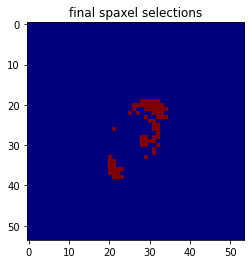

Final no. of spaxels picked: 66
Total estimated fitting time (hours): 198


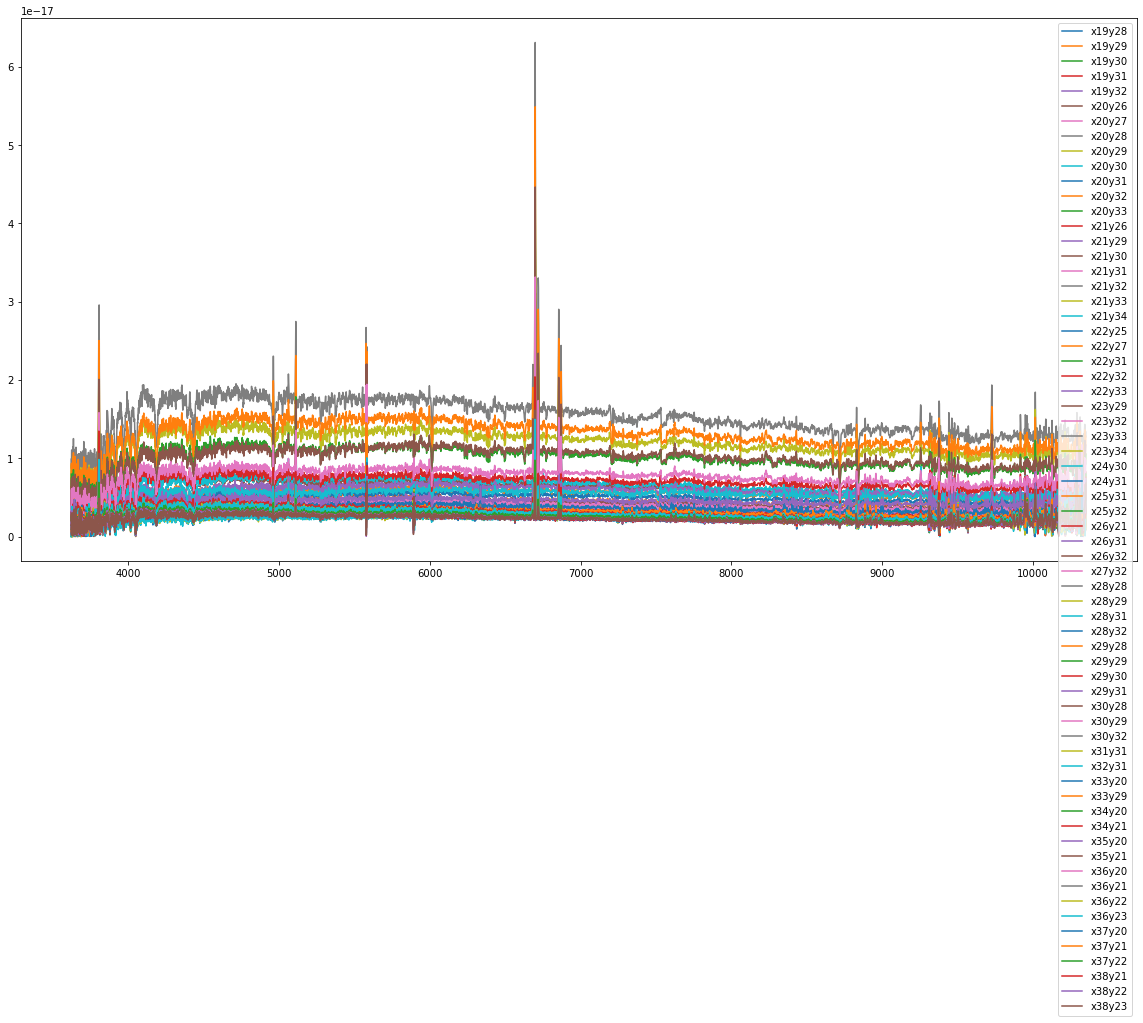

In [182]:
for i,gal in enumerate(galaxies):
    if IDs[i] == '8085-6104':
        gal.mask_spaxels(SNR_threshold=15, qualmask_choice='both', min_spaxels_no=10)
        gal.get_spaxels()
        fig, ax = plt.subplots(figsize=[20,10])
        for i,key in enumerate(gal.spaxel_picked_spectra.keys()):
            this_spec = gal.spaxel_picked_spectra[key]
            #print(len(this_spec['wavelength']))
            a1 = plt.plot(this_spec['wavelength'], this_spec['spectrum'], label=key)
            #plt.fill_between(this_spec['wavelength'], this_spec['spectrum']-this_spec['error'], 
            #                this_spec['spectrum']+this_spec['error'], color=a1[0].get_color(), alpha=0.5)
        plt.legend()
        plt.show()